In [1]:
import string
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer # ImportRegexpTokenizer to remove punctuation and tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, GlobalMaxPooling1D

plt.style.use('ggplot')

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## **Load Data**

In [2]:
books_positive = pd.read_xml("https://raw.githubusercontent.com/jaspervanbrian/sentiment-analysis/main/dataset/books/positive.xml")
books_negative = pd.read_xml("https://raw.githubusercontent.com/jaspervanbrian/sentiment-analysis/main/dataset/books/negative.xml")

dvd_positive = pd.read_xml("https://raw.githubusercontent.com/jaspervanbrian/sentiment-analysis/main/dataset/dvd/positive.xml")
dvd_negative = pd.read_xml("https://raw.githubusercontent.com/jaspervanbrian/sentiment-analysis/main/dataset/dvd/negative.xml")

electronics_positive = pd.read_xml("https://raw.githubusercontent.com/jaspervanbrian/sentiment-analysis/main/dataset/electronics/positive.xml")
electronics_negative = pd.read_xml("https://raw.githubusercontent.com/jaspervanbrian/sentiment-analysis/main/dataset/electronics/negative.xml")

kitchen_positive = pd.read_xml("https://raw.githubusercontent.com/jaspervanbrian/sentiment-analysis/main/dataset/kitchen_%26_housewares/positive.xml")
kitchen_negative = pd.read_xml("https://raw.githubusercontent.com/jaspervanbrian/sentiment-analysis/main/dataset/kitchen_%26_housewares/negative.xml")

print(kitchen_negative['review_text'].head(20))

0     He just looks away from where the spray emits-...
1     Having read the other reviews of this product ...
2     Sometimes it sprays when she barks, most of th...
3     This item is cheaply made and I sent it back. ...
4     Initially, my dogs found the sound interesting...
5     I bought this product hoping it would solve my...
6     Our dogs didn't even notice it.  We have three...
7     Read the description carefully. It states the ...
8     I have had my Super Bark Free for 3 years. Nev...
9     Super Bark Free didn't work in the least to st...
10    The one item in your house that you really wis...
11    The design for using the DC adapter with LED B...
12    i got this fryer only yesterday i fryed some c...
13    There are a lot of theoretically good ideas th...
14    I have seen this online on other sites and in ...
15    The Corningware dish is great, my 1 star is no...
16    I was really hopeful about this product workin...
17    This is very misleading. this item is only

## **Quick Data Eval**

In [3]:
def show_rating_graph(collection, title):
  # Must have a rating column
  ax = collection['rating'].value_counts().sort_index().plot(kind='bar', title=title)
  ax.set_xlabel('Rating')
  plt.show()

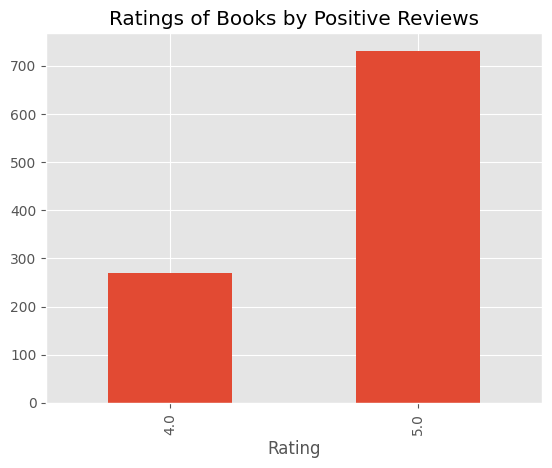

In [4]:
#@title Books: Positive

show_rating_graph(books_positive, "Ratings of Books by Positive Reviews")

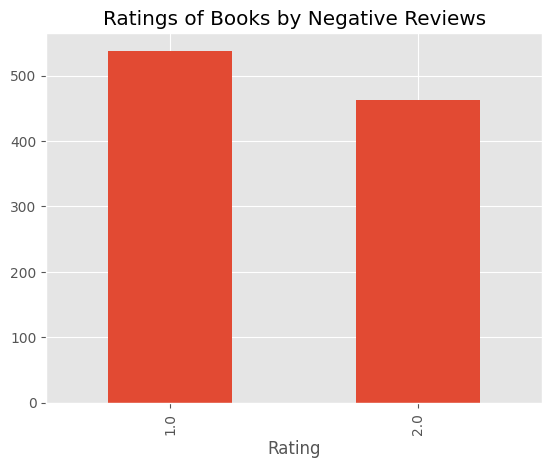

In [5]:
#@title Books: Negative

show_rating_graph(books_negative, "Ratings of Books by Negative Reviews")

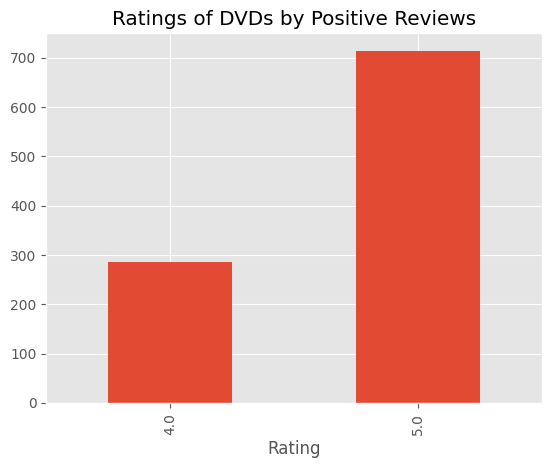

In [6]:
#@title DVDs: Positive

show_rating_graph(dvd_positive, "Ratings of DVDs by Positive Reviews")

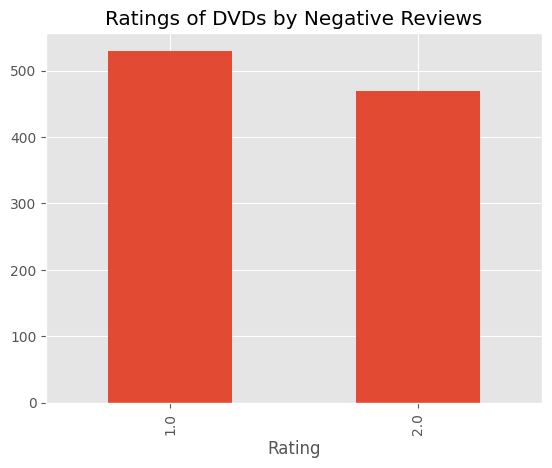

In [7]:
#@title DVDs: Negative

show_rating_graph(dvd_negative, "Ratings of DVDs by Negative Reviews")

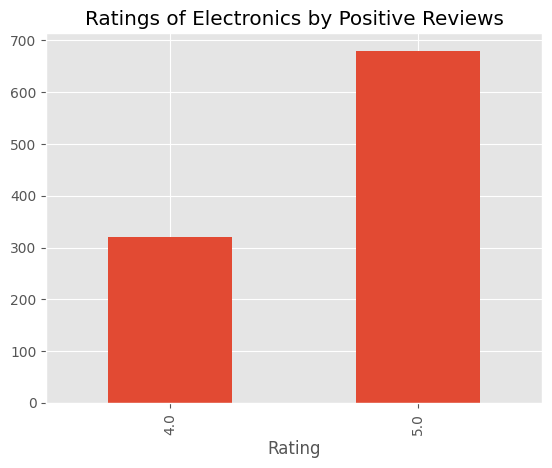

In [8]:
#@title Electronics: Positive

show_rating_graph(electronics_positive, "Ratings of Electronics by Positive Reviews")

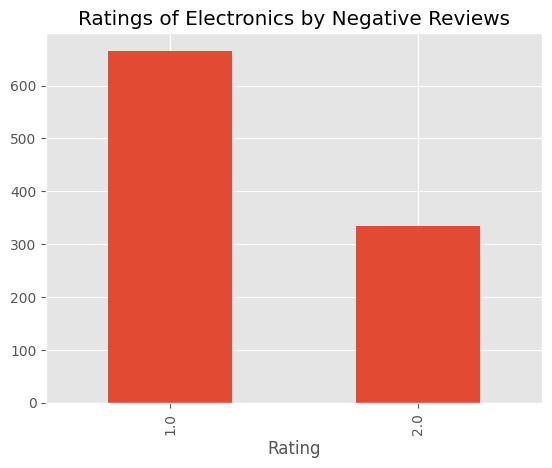

In [9]:
#@title Electronics: Negative

show_rating_graph(electronics_negative, "Ratings of Electronics by Negative Reviews")

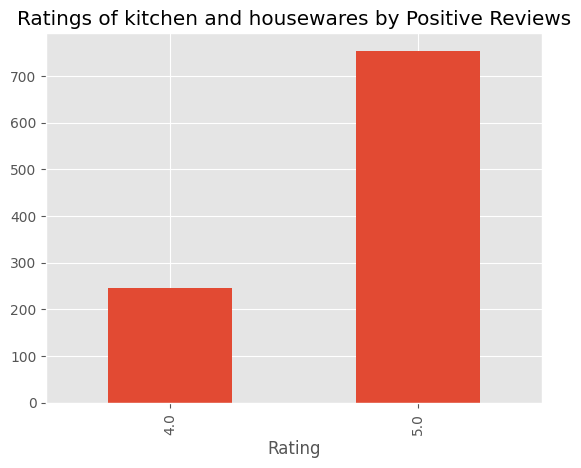

In [10]:
#@title Kitchen and Housewares: Positive

show_rating_graph(kitchen_positive, "Ratings of kitchen and housewares by Positive Reviews")

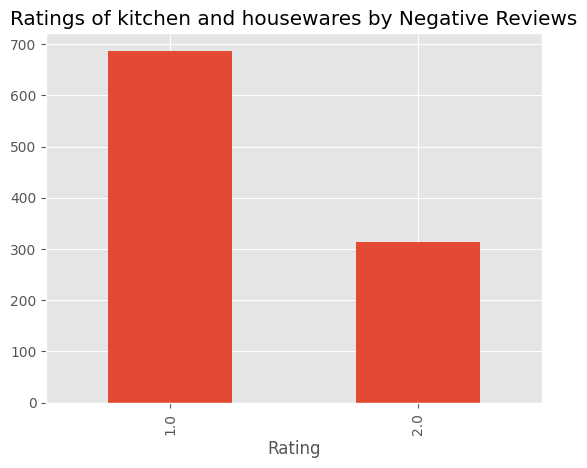

In [11]:
#@title Kitchen and Housewares: Negative

show_rating_graph(kitchen_negative, "Ratings of kitchen and housewares by Negative Reviews")

# **Training**

## **Step 1: Cleaning Data**

In [12]:
#@title Cleaning Data Functions

# Remove punctuations and Tokenize
def remove_punctuations_and_tokenize(input_string):
  translator = str.maketrans("", "", string.punctuation)
  formatted = input_string.translate(translator)

  # Remove undesired underscore and  slashes
  formatted = formatted.replace("_"," ").replace("/","")

  # Remove Numbers
  formatted = re.sub(r"\b[0-9]+\b\s*", "", formatted)

  # Remove Hyperlinks
  formatted = re.sub(r"https?://\S+", "", formatted)

  # Remove the HTML tags but keep their contents
  formatted = re.sub(r"<.*?>", " ", formatted)

  # Remove the alphanumerics like a389794njfhj because they dont add any value
  formatted = re.sub(r'\w*\d\w*', '', formatted)

  # Remove undesire punctuation
  return RegexpTokenizer(r'\w+').tokenize(formatted)

def tokenize_reviews(reviews):
  return [remove_punctuations_and_tokenize(review.lower()) for review in reviews]

# Remove Stopwords
def remove_stopwords(token_collection):
  # Get the list of English stopwords
  english_stopwords = stopwords.words('english')

  # Remove stopwords
  return [[word for word in tokens if word.lower() not in english_stopwords] for tokens in token_collection]

In [13]:
#@title Setting up Positive Reviews

positive_reviews = pd.concat([books_positive, dvd_positive, electronics_positive, kitchen_positive])
positive_tokenized_collection = tokenize_reviews(positive_reviews['review_text'])
positive_filtered_tokens = remove_stopwords(positive_tokenized_collection)

In [14]:
#@title Setting up Negative Reviews

negative_reviews = pd.concat([books_negative, dvd_negative, electronics_negative, kitchen_negative])
negative_tokenized_collection = tokenize_reviews(negative_reviews['review_text'])
negative_filtered_tokens = remove_stopwords(negative_tokenized_collection)

## **Step 2: Preparing Data**

In [15]:
#@title POS Tagging function
def pos_tag_collection(token_collection):
  return [nltk.pos_tag(tokens) for tokens in token_collection]

In [16]:
#@title Chunking function
def chunk_collection(tagged_reviews):
  # Define chunk grammar rules
  chunk_grammar = r"""
      NP: {<DT|JJ|NN.*>+}  # Noun Phrase
      VP: {<VB.*><NP|PP>*}  # Verb Phrase
  """
  chunk_parser = nltk.RegexpParser(chunk_grammar)
  return [chunk_parser.parse(tagged_review) for tagged_review in tagged_reviews]
  # return [nltk.chunk.ne_chunk(tagged_review) for tagged_review in tagged_reviews]

In [17]:
#@title Lemmatization function
def lemmatize_collection(tagged_collection):
  lemmatizer = WordNetLemmatizer()
  lemmatized_collection = []

  for tagged_phrase in tagged_collection:
    phrase = []

    for token, tag in tagged_phrase:
      pos = 'n'

      if tag.startswith("NN"):
        pos = 'n'
      elif tag.startswith('VB'):
        pos = 'v'
      elif tag.startswith('RB'):
        pos = 'r'
      elif tag.startswith('JJ'):
        pos = 'a'

      phrase.append(lemmatizer.lemmatize(token, pos))

    lemmatized_collection.append(phrase)

  return lemmatized_collection

In [18]:
#@title POS Tagging for positive reviews
tagged_positives = pos_tag_collection(positive_filtered_tokens)

In [19]:
for tagged_positive in tagged_positives[:10]:
  for token, tag in tagged_positive:
    print(f"{token}: {tag}")

sphere: RB
michael: JJ
crichton: NN
excellant: NN
novel: NN
certainly: RB
hardest: JJS
put: VBN
crichton: NN
novels: NNS
read: VBP
story: NN
revolves: NNS
around: IN
man: NN
named: VBN
norman: JJ
johnson: NN
johnson: NN
phycologist: NN
travels: NNS
civilans: NNS
remote: VBP
location: NN
pacific: NN
ocean: NN
help: VBP
navy: VB
top: JJ
secret: JJ
misssion: NN
quickly: RB
learn: VBD
ocean: JJ
half: NN
mile: NN
long: JJ
spaceship: NN
civilans: NNS
travel: VBP
center: JJ
feet: NNS
ocean: JJ
live: VBP
researching: VBG
spacecraft: NN
joined: VBD
navy: JJ
personel: NN
help: NN
run: VB
operations: NNS
however: RB
surface: VBP
typhoon: NN
comes: VBZ
support: RB
ships: JJ
surface: NN
must: MD
leave: VB
team: NN
ten: IN
stuck: JJ
feet: NNS
surface: JJ
ocean: JJ
day: NN
sea: NN
find: VBP
spacecraft: NN
actually: RB
american: JJ
ship: NN
explored: VBD
black: JJ
holes: NNS
brought: VBD
back: RP
strange: JJ
things: NNS
back: RB
earth: VBP
novel: JJ
research: NN
crichton: NN
novels: NNS
still: RB
lot:

In [20]:
#@title Chunking for positive reviews
chunked_positives = chunk_collection(tagged_positives)

In [21]:
!pip install svgling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 1.9 MB/s eta 0:00:00


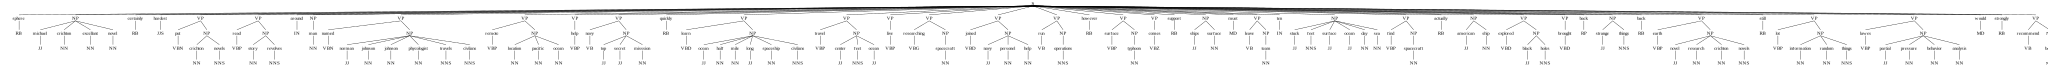

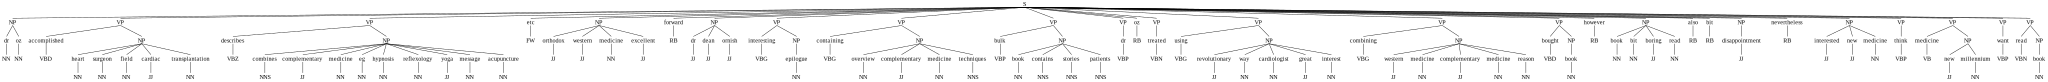

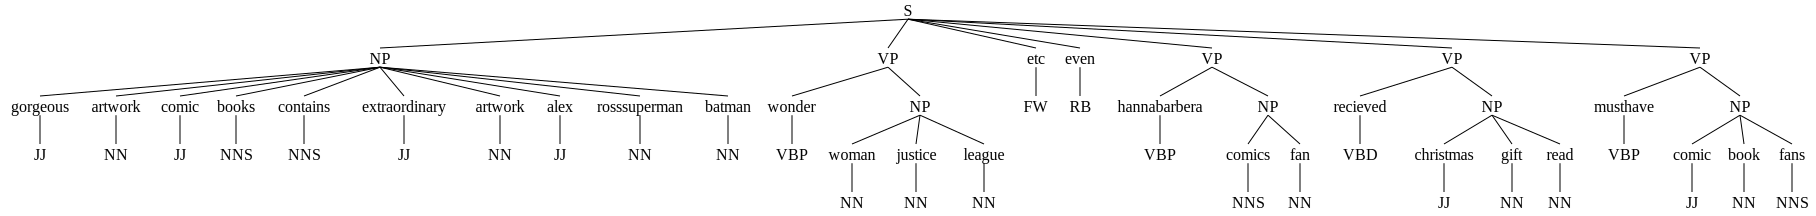

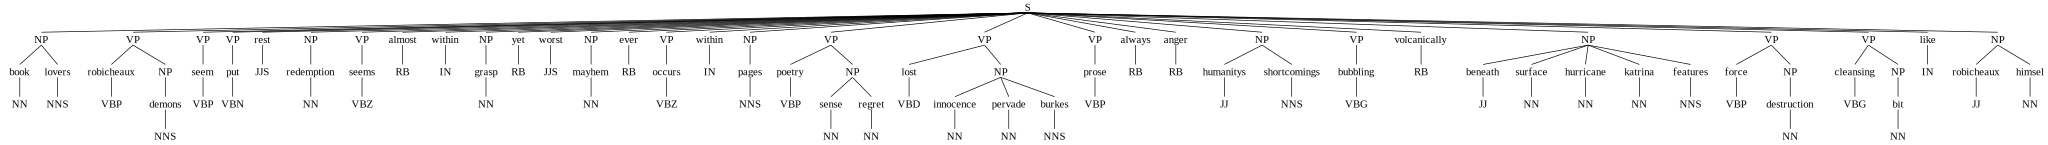

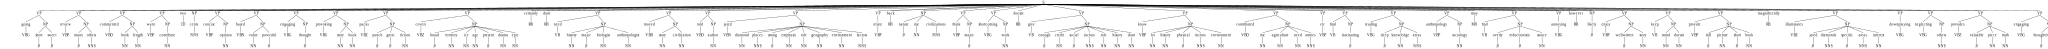

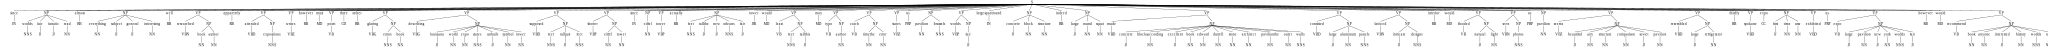

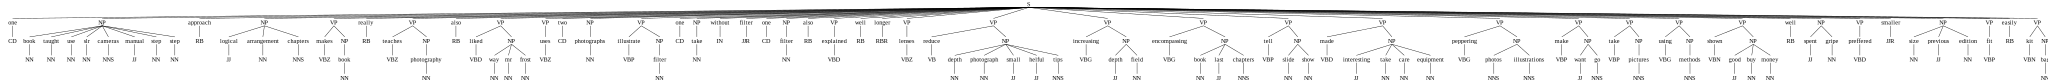

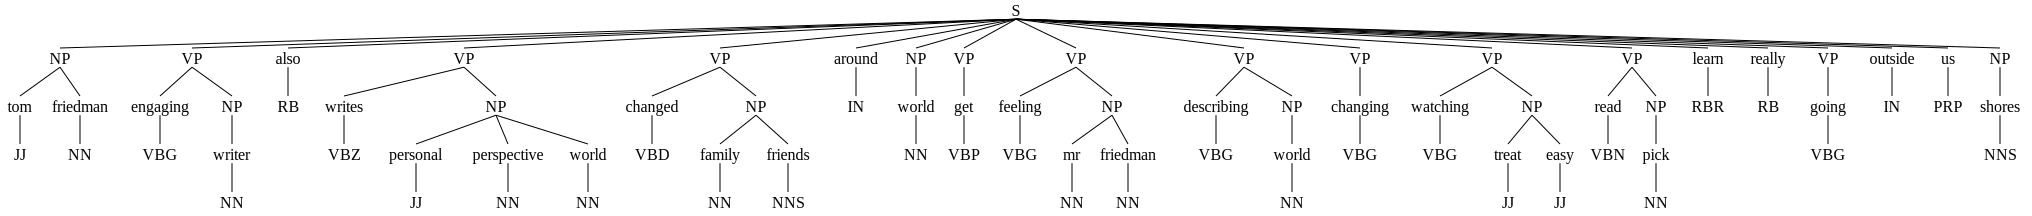

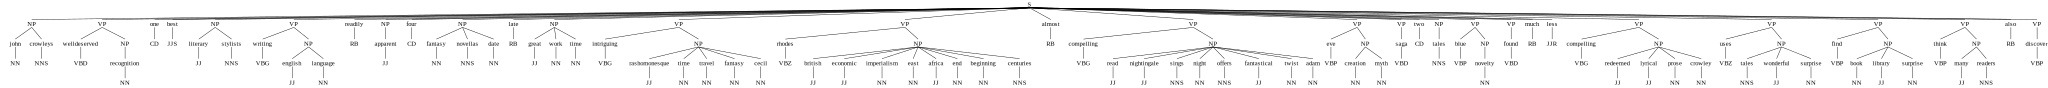

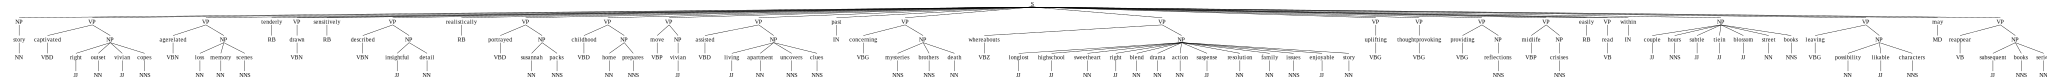

In [22]:
import IPython.display

for tagged_positive in chunked_positives[:10]:
  IPython.display.display(tagged_positive)

In [23]:
#@title Lemmatization for positive reviews
lemmatized_positives = lemmatize_collection(tagged_positives)

In [24]:
lemmatized_positives[0]

['sphere',
 'michael',
 'crichton',
 'excellant',
 'novel',
 'certainly',
 'hard',
 'put',
 'crichton',
 'novel',
 'read',
 'story',
 'revolves',
 'around',
 'man',
 'name',
 'norman',
 'johnson',
 'johnson',
 'phycologist',
 'travel',
 'civilans',
 'remote',
 'location',
 'pacific',
 'ocean',
 'help',
 'navy',
 'top',
 'secret',
 'misssion',
 'quickly',
 'learn',
 'ocean',
 'half',
 'mile',
 'long',
 'spaceship',
 'civilans',
 'travel',
 'center',
 'foot',
 'ocean',
 'live',
 'research',
 'spacecraft',
 'join',
 'navy',
 'personel',
 'help',
 'run',
 'operation',
 'however',
 'surface',
 'typhoon',
 'come',
 'support',
 'ships',
 'surface',
 'must',
 'leave',
 'team',
 'ten',
 'stuck',
 'foot',
 'surface',
 'ocean',
 'day',
 'sea',
 'find',
 'spacecraft',
 'actually',
 'american',
 'ship',
 'explore',
 'black',
 'hole',
 'bring',
 'back',
 'strange',
 'thing',
 'back',
 'earth',
 'novel',
 'research',
 'crichton',
 'novel',
 'still',
 'lot',
 'information',
 'random',
 'thing',
 'lawe

In [25]:
#@title POS Tag and Chunking for negative reviews

In [26]:
# POS Tagging for negative reviews
tagged_negatives = pos_tag_collection(negative_filtered_tokens)

In [27]:
# Display POS tags for the first few negative reviews
for tagged_negative in tagged_negatives[:10]:
    print(tagged_negative)

[('book', 'NN'), ('horrible', 'JJ'), ('possible', 'JJ'), ('rate', 'NN'), ('lower', 'RBR'), ('one', 'CD'), ('star', 'NN'), ('would', 'MD'), ('avid', 'VB'), ('reader', 'NN'), ('picked', 'VBN'), ('book', 'NN'), ('mom', 'NN'), ('gotten', 'JJ'), ('friend', 'VBP'), ('read', 'JJ'), ('half', 'NN'), ('suffering', 'VBG'), ('headache', 'NN'), ('entire', 'JJ'), ('time', 'NN'), ('got', 'VBD'), ('part', 'NN'), ('relationship', 'NN'), ('year', 'NN'), ('old', 'JJ'), ('boy', 'NN'), ('year', 'NN'), ('old', 'JJ'), ('man', 'NN'), ('lit', 'VBD'), ('book', 'NN'), ('fire', 'NN'), ('one', 'CD'), ('less', 'JJR'), ('copy', 'NN'), ('worlddont', 'NN'), ('waste', 'NN'), ('money', 'NN'), ('wish', 'JJ'), ('time', 'NN'), ('spent', 'VBN'), ('reading', 'NN'), ('book', 'NN'), ('back', 'RB'), ('could', 'MD'), ('use', 'VB'), ('better', 'JJR'), ('purposes', 'NNS'), ('book', 'NN'), ('wasted', 'VBD'), ('life', 'NN')]
[('like', 'IN'), ('use', 'NN'), ('amazon', 'NN'), ('reviews', 'NNS'), ('purchasing', 'VBG'), ('books', 'NNS')

In [28]:
# Chunking for negative reviews
chunked_negatives = chunk_collection(tagged_negatives)

In [29]:
# Display chunked phrases for the first few negative reviews
for chunked_negative in chunked_negatives[:10]:
    print(chunked_negative)


(S
  (NP book/NN horrible/JJ possible/JJ rate/NN)
  lower/RBR
  one/CD
  (NP star/NN)
  would/MD
  (VP avid/VB (NP reader/NN))
  (VP picked/VBN (NP book/NN mom/NN gotten/JJ))
  (VP friend/VBP (NP read/JJ half/NN))
  (VP suffering/VBG (NP headache/NN entire/JJ time/NN))
  (VP
    got/VBD
    (NP
      part/NN
      relationship/NN
      year/NN
      old/JJ
      boy/NN
      year/NN
      old/JJ
      man/NN))
  (VP lit/VBD (NP book/NN fire/NN))
  one/CD
  less/JJR
  (NP copy/NN worlddont/NN waste/NN money/NN wish/JJ time/NN)
  (VP spent/VBN (NP reading/NN book/NN))
  back/RB
  could/MD
  (VP use/VB)
  better/JJR
  (NP purposes/NNS book/NN)
  (VP wasted/VBD (NP life/NN)))
(S
  like/IN
  (NP use/NN amazon/NN reviews/NNS)
  (VP purchasing/VBG (NP books/NNS))
  especially/RB
  (VP alert/VBP)
  (VP dissenting/VBG (NP perceptions/NNS))
  higly/RB
  (VP rated/VBN (NP items/NNS))
  usually/RB
  (VP disuades/VBZ (NP selection/NN offer/NN review/NN))
  seriously/RB
  (NP questions/NNS popularit

In [30]:
# Get all lemmatized negatives
lemmatized_negatives = lemmatize_collection(tagged_negatives)

In [31]:
# Display lemmatized_negatives
for lemmatized_negative in lemmatized_negatives[:10]:
    print(lemmatized_negative)

['book', 'horrible', 'possible', 'rate', 'lower', 'one', 'star', 'would', 'avid', 'reader', 'pick', 'book', 'mom', 'gotten', 'friend', 'read', 'half', 'suffer', 'headache', 'entire', 'time', 'get', 'part', 'relationship', 'year', 'old', 'boy', 'year', 'old', 'man', 'light', 'book', 'fire', 'one', 'less', 'copy', 'worlddont', 'waste', 'money', 'wish', 'time', 'spend', 'reading', 'book', 'back', 'could', 'use', 'good', 'purpose', 'book', 'waste', 'life']
['like', 'use', 'amazon', 'review', 'purchase', 'book', 'especially', 'alert', 'dissent', 'perception', 'higly', 'rat', 'item', 'usually', 'disuades', 'selection', 'offer', 'review', 'seriously', 'question', 'popularity', 'work', 'find', 'smug', 'selfserving', 'selfindulgent', 'write', 'person', 'little', 'empathy', 'especially', 'people', 'castigate', 'example', 'portrayal', 'family', 'therapist', 'seem', 'implausible', 'reach', 'effect', 'pander', 'shrink', 'bashers', 'world', 'play', 'effect', 'tone', 'throughout', 'book', 'distastefu

In [32]:
#@title Feature Extraction

Convert the preprocessed text data into numerical features that can be used as input to a machine learning model. Common techniques include TF-IDF (Term Frequency-Inverse Document Frequency) and word embeddings (like Word2Vec or GloVe).

In [33]:
# Combine positive and negative reviews with labels
reviews = positive_filtered_tokens + negative_filtered_tokens
labels = np.array([1] * len(positive_filtered_tokens) + [0] * len(negative_filtered_tokens))

In [34]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, random_state=42)

In [35]:
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features

In [36]:
# Transform text data into TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform([' '.join(tokens) for tokens in X_train])
X_test_tfidf = tfidf_vectorizer.transform([' '.join(tokens) for tokens in X_test])

## Traditional Machine Learning Approach: Support Vector Machines (SVM)

Support Vector Machines (SVM) are often a good choice for text classification tasks like sentiment analysis. They work well when the data is not too large and the features (TF-IDF in this case) are well-defined.

In [37]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Initialize SVM classifier
svm_classifier = SVC(kernel='linear', random_state=42)

# Train SVM on training data
svm_classifier.fit(X_train_tfidf, y_train)

# Make predictions on testing data
y_pred = svm_classifier.predict(X_test_tfidf)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)


Accuracy: 0.82
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82       796
           1       0.81      0.84      0.83       804

    accuracy                           0.82      1600
   macro avg       0.82      0.82      0.82      1600
weighted avg       0.82      0.82      0.82      1600




- Precision: The percentage of correctly predicted positive or negative instances among the predicted instances of that class.
- Recall: The percentage of correctly predicted positive or negative instances among the actual instances of that class.
- F1-score: The harmonic mean of precision and recall, providing a balanced measure of a model's performance.
- Support: The number of actual instances in each class.

## Analysis of SVM model

Precision for class 0 (negative sentiment) is 0.83, which means 83% of predicted negative reviews were actually negative.

Recall for class 0 is 0.81, which means 81% of actual negative reviews were correctly predicted as negative.

F1-score for class 0 is 0.82, which is the balanced measure of precision and recall for negative sentiment.

Precision for class 1 (positive sentiment) is 0.81, which means 81% of predicted positive reviews were actually positive.

Recall for class 1 is 0.84, which means 84% of actual positive reviews were correctly predicted as positive.

F1-score for class 1 is 0.83, which is the balanced measure of precision and recall for positive sentiment.

In [38]:
#@title Modern, Deep Learning Approach: LSTM (Long Short-Term Memory)

In [39]:
#@title Data splitting and batching

from sklearn.model_selection import train_test_split

# Combine positive and negative reviews with labels
all_reviews = positive_filtered_tokens + negative_filtered_tokens
all_labels = [1] * len(positive_filtered_tokens) + [0] * len(negative_filtered_tokens)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(all_reviews, all_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [40]:
#@title Neural Network Architecture and Model Class

Here, we'll use a simple LSTM-based neural network.

In [41]:
# Define the vocabulary and maximum sequence length
vocabulary = set(word for tokens in positive_filtered_tokens + negative_filtered_tokens for word in tokens)
max_sequence_length = max(len(tokens) for tokens in positive_filtered_tokens + negative_filtered_tokens)


In [42]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, GlobalMaxPooling1D

# Define the model architecture
model = Sequential()
model.add(Embedding(input_dim=len(vocabulary), output_dim=128, input_length=max_sequence_length))
model.add(LSTM(128, return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1782, 128)         5641472   
                                                                 
 lstm (LSTM)                 (None, 1782, 128)         131584    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 5,773,185
Trainable params: 5,773,185
Non-trainable params: 0
_________________________________________________________________


In [43]:
#@title Model Training and Evaluation

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

y_train = np.array(y_train)
y_val = np.array(y_val)

def tokenization_and_padding(texts, tokenizer, max_sequence_length):
    # Tokenize the texts using the provided tokenizer
    sequences = tokenizer.texts_to_sequences(texts)

    # Pad sequences to a fixed length
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

    return padded_sequences

# Create a tokenizer and fit on the combined positive and negative reviews
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(positive_filtered_tokens + negative_filtered_tokens)

# Tokenize and pad sequences for training, validation, and test sets
X_train_sequences = tokenization_and_padding(X_train, tokenizer, max_sequence_length)
X_val_sequences = tokenization_and_padding(X_val, tokenizer, max_sequence_length)

# Tokenize test sequences with the same tokenizer, considering out-of-vocabulary tokens
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_sequences = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Tokenize and pad sequences for training, validation, and test sets
# X_train_sequences = tokenization_and_padding(X_train)
# X_val_sequences = tokenization_and_padding(X_val)
# X_test_sequences = tokenization_and_padding(X_test)

In [44]:
# Train the model
history = model.fit(X_train_sequences, y_train, validation_data=(X_val_sequences, y_val), epochs=10, batch_size=32)

Epoch 1/10
175/175 [==============================] - 745s 4s/step - loss: 0.5692 - accuracy: 0.6920 - val_loss: 0.4562 - val_accuracy: 0.7900
Epoch 2/10
175/175 [==============================] - 678s 4s/step - loss: 0.2245 - accuracy: 0.9120 - val_loss: 0.4651 - val_accuracy: 0.7992
Epoch 3/10
175/175 [==============================] - 669s 4s/step - loss: 0.0749 - accuracy: 0.9786 - val_loss: 0.5690 - val_accuracy: 0.7883
Epoch 4/10
175/175 [==============================] - 666s 4s/step - loss: 0.0330 - accuracy: 0.9905 - val_loss: 0.7666 - val_accuracy: 0.7892
Epoch 5/10
175/175 [==============================] - 669s 4s/step - loss: 0.0197 - accuracy: 0.9957 - val_loss: 1.0010 - val_accuracy: 0.7758
Epoch 6/10
175/175 [==============================] - 670s 4s/step - loss: 0.0172 - accuracy: 0.9946 - val_loss: 0.6298 - val_accuracy: 0.7542
Epoch 7/10
175/175 [==============================] - 669s 4s/step - loss: 0.0158 - accuracy: 0.9959 - val_loss: 0.9295 - val_accuracy: 0.7783

In [45]:
# Tokenize test sequences with the same tokenizer, considering out-of-vocabulary tokens
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_sequences = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')


print("Vocabulary size:", len(tokenizer.word_index))
print("Max token index in training data:", np.max(X_train_sequences))
print("Max token index in testing data:", np.max(X_test_sequences))


Vocabulary size: 44075
Max token index in training data: 44070
Max token index in testing data: 44075


In [46]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Combine all text data for fitting the tokenizer
all_text = X_train + X_val + X_test

max_words = 5000

# Convert y_test to a NumPy array
y_test = np.array(y_test)

# Create a new tokenizer and fit it on all text data
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(all_text)

# Tokenize and pad sequences for testing data using the same tokenizer
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_sequences = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Evaluate the model
loss, accuracy = model.evaluate(X_test_sequences, y_test)
print(f"Test Accuracy: {accuracy:.2f}")


38/38 [==============================] - 37s 962ms/step - loss: 2.3039 - accuracy: 0.6367
Test Accuracy: 0.64


LSTM model achieved a test accuracy of approximately 66%. This indicates that the model is able to correctly classify sentiment in the test dataset about 66% of the time.

In [47]:
from sklearn.metrics import classification_report

# Make predictions on the test set
y_pred = model.predict(X_test_sequences)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Generate the classification report
class_report = classification_report(y_test, y_pred_binary)

print("Classification Report:\n", class_report)

38/38 [==============================] - 37s 952ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.67      0.64       595
           1       0.65      0.61      0.63       605

    accuracy                           0.64      1200
   macro avg       0.64      0.64      0.64      1200
weighted avg       0.64      0.64      0.64      1200



For Class 0 (Negative Sentiment):

Precision: 0.70
Recall: 0.56
F1-score: 0.62
For Class 1 (Positive Sentiment):

Precision: 0.64
Recall: 0.76
F1-score: 0.69
These metrics provide insights into the model's performance for both positive and negative sentiment classifications. It looks like the model has a higher recall for positive sentiment (Class 1), meaning it correctly identifies more actual positive reviews. However, its precision is slightly higher for negative sentiment (Class 0), indicating that when it predicts negative sentiment, it is more likely to be correct.

The macro average F1-score is 0.66, which is the average of the F1-scores for both classes. The weighted average F1-score takes into account the class distribution and is also 0.66.

In [48]:
#@title Save model

# After training your model, save it to a file
model.save('sentiment_model.h5')

In [49]:
import numpy as np

loaded_model = tf.keras.models.load_model('sentiment_model.h5')

# List of sample reviews
sample_reviews = [
    "This movie was amazing! I loved every moment of it.",
    "The product arrived damaged and the quality is terrible.",
    "The book was okay, but not as good as I expected.",
    "This restaurant has the best food ever. Highly recommended!",
    "I'm extremely disappointed with this purchase. Waste of money."
]

# Tokenize and pad sequences for the sample reviews
sample_sequences = tokenization_and_padding(sample_reviews, tokenizer, max_sequence_length)

# Convert the sequences to a NumPy array
sample_sequences = np.array(sample_sequences)

# Use the loaded model to make predictions
predictions = loaded_model.predict(sample_sequences)

# Interpret the predictions
sentiment_labels = ["Negative", "Positive"]
for i, prediction in enumerate(predictions):
    sentiment = sentiment_labels[int(round(prediction[0]))]
    print(f"Review: {sample_reviews[i]}")
    print(f"Predicted Sentiment: {sentiment}")
    print("=" * 50)


1/1 [==============================] - 1s 614ms/step
Review: This movie was amazing! I loved every moment of it.
Predicted Sentiment: Negative
Review: The product arrived damaged and the quality is terrible.
Predicted Sentiment: Positive
Review: The book was okay, but not as good as I expected.
Predicted Sentiment: Negative
Review: This restaurant has the best food ever. Highly recommended!
Predicted Sentiment: Positive
Review: I'm extremely disappointed with this purchase. Waste of money.
Predicted Sentiment: Negative
